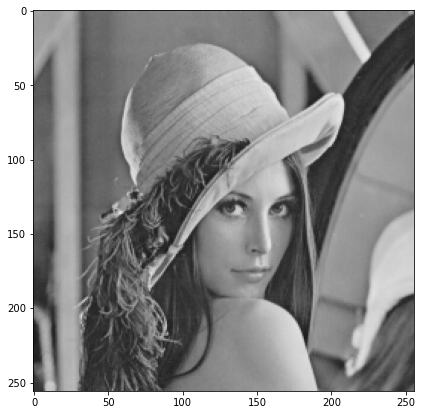

In [2]:
#Importando as bibliotecas
import time
import numpy
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7) #Definir o tamanho da imagem que vai aparecer na tela

#Lendo e mostrando a imagem
imagem = cv2.imread('resources/imgs/lena256.png', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
plt.show()